In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import scipy as sp
import scipy.ndimage
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.decomposition import FastICA

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline
plt.rcParams.update({'font.size': 20})

### Lets start with zscored behavior and multivariate. 

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

In [3]:
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 15.82 sec
brain shape is x,y,z,t (128, 84, 49, 4554)


In [4]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 68.88 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec


In [5]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time()-t0))

Duration: 28.510226249694824


In [6]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [7]:
resolution = 50 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

Text(0.5, 1.0, 'Brain interp space zoom')

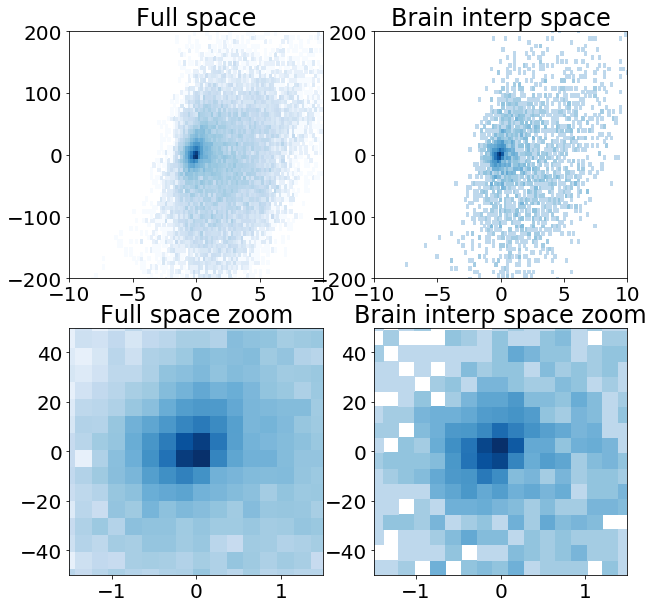

In [8]:
plt.figure(figsize=(10,10))
#norm = None
norm = mpl.colors.LogNorm()
#norm = mpl.colors.PowerNorm(.2)

plt.subplot(221)
plt.hist2d(fictracs_high_res['Y'],fictracs_high_res['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylim(-200,200)
plt.xlim(-10,10)
plt.title('Full space')

plt.subplot(222)
plt.hist2d(np.repeat(fictracs['Y'],10),
           np.repeat(fictracs['Z'],10),
           bins=100,cmap='Blues',norm=norm);
plt.ylim(-200,200)
plt.xlim(-10,10)
plt.title('Brain interp space')

plt.subplot(223)
plt.hist2d(fictracs_high_res['Y'],fictracs_high_res['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylim(-50,50)
plt.xlim(-1.5,1.5)
plt.title('Full space zoom')

plt.subplot(224)
h = plt.hist2d(np.repeat(fictracs['Y'],10),
           np.repeat(fictracs['Z'],10),
           bins=100,cmap='Blues',norm=norm);
plt.ylim(-50,50)
plt.xlim(-1.5,1.5)
plt.title('Brain interp space zoom')

### Z-score PCA and Fictrac

In [9]:
pca_loadings_std = np.std(pca_loadings,axis=0)
pca_loadings= np.divide(pca_loadings,pca_loadings_std)

In [10]:
for behavior in ['Y', 'Z']:
    fictracs_std = np.std(fictracs[behavior])
    fictracs[behavior] = np.divide(fictracs[behavior],fictracs_std)

# Shuffle fictrac if desired

In [199]:
np.random.shuffle(fictracs['Y'])
np.random.shuffle(fictracs['Z'])

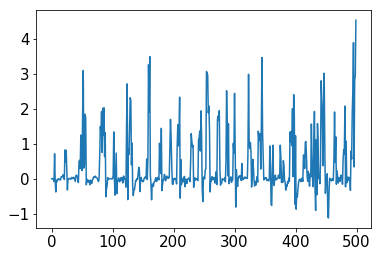

In [198]:
plt.plot(fictracs['Y'][:500])

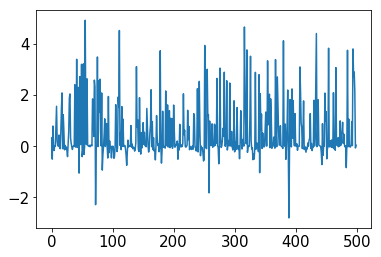

In [200]:
plt.plot(fictracs['Y'][:500])

# Fit models

In [46]:
#### Predict behavior ####

models = {}
for behavior in ['Y', 'Z']:
    models[behavior] = []
    for num_pcs in [10,25,50,75,100,200,300,500]:
        Y_glm = fictracs[behavior]
        t0 = time()
        models[behavior].append({'num_pcs': num_pcs, 'model': LassoCV()})
        X_glm = pca_loadings[:,:num_pcs]
        models[behavior][-1]['model'].fit(X_glm, Y_glm)
        models[behavior][-1]['score'] = models[behavior][-1]['model'].score(X_glm, Y_glm)
        print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 10, Duration: 0.05082130432128906 sec
Num PCs: 25, Duration: 0.04597353935241699 sec
Num PCs: 50, Duration: 0.06271004676818848 sec
Num PCs: 75, Duration: 0.08533143997192383 sec
Num PCs: 100, Duration: 0.10883212089538574 sec
Num PCs: 200, Duration: 0.2454686164855957 sec
Num PCs: 300, Duration: 0.4329066276550293 sec
Num PCs: 500, Duration: 1.180506944656372 sec
Num PCs: 10, Duration: 0.04244112968444824 sec
Num PCs: 25, Duration: 0.04619646072387695 sec
Num PCs: 50, Duration: 0.06522297859191895 sec
Num PCs: 75, Duration: 0.09833121299743652 sec
Num PCs: 100, Duration: 0.1260664463043213 sec
Num PCs: 200, Duration: 0.26711249351501465 sec
Num PCs: 300, Duration: 0.5159201622009277 sec
Num PCs: 500, Duration: 1.4193758964538574 sec


In [11]:
#### Multivariate model!!! ####

models = []
for num_pcs in [100]:
#for num_pcs in [200]:
    Y_glm = np.vstack((fictracs['Y'], fictracs['Z'])).T
    t0 = time()
    models.append({'num_pcs': num_pcs, 'model': MultiTaskLassoCV()})
    X_glm = pca_loadings[:,:num_pcs]
    models[-1]['model'].fit(X_glm, Y_glm)
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 100, Duration: 6.19678807258606 sec


##### Start side play

In [ ]:
#The coefficient R^2 is defined as (1 - u/v),
#where u is the residual sum of squares ((y_true - y_pred) ** 2).sum()
#and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()

In [ ]:
# YES, the output score is the avg of Z and Y scores...
# Yes, I think this is the best R2 calculation...

In [22]:
u = np.sum((prediction[:,0]-fictracs['Y'])**2)
v = np.sum((fictracs['Y']-np.mean(fictracs['Y']))**2)
1 - u / v

0.4583669803267113

In [23]:
u = np.sum((prediction[:,1]-fictracs['Z'])**2)
v = np.sum((fictracs['Z']-np.mean(fictracs['Z']))**2)
1 - u / v

0.3429676258101819

In [24]:
(0.3429676258101819 + 0.4583669803267113) / 2

0.4006673030684466

In [13]:
models[-1]['score']

0.4006673030684456

In [14]:
#Y_glm = np.vstack((fictracs['Y'], fictracs['Z'])).T
X_glm = pca_loadings[:,:100]
prediction = models[0]['model'].predict(X_glm)

In [15]:
np.shape(prediction)

(4554, 2)

(0, 500)

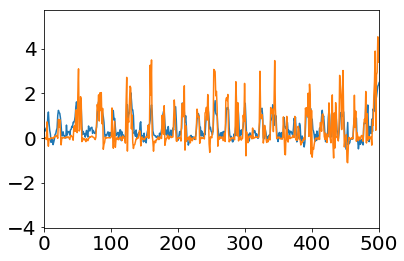

In [17]:
plt.plot(prediction[:,0])
plt.plot(fictracs['Y'])
plt.xlim(0,500)

##### End side play

Text(0.5, 0.98, 'SHUFFLE. MultiTaskLassoCV, fly_19, z-scored PCs and behavior')

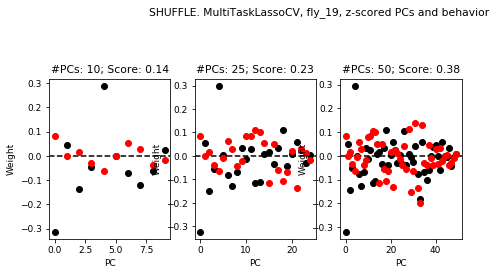

In [239]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 9})

for model_num in range(len(models)):
    plt.subplot(3,4,model_num+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(models[model_num]['model'].coef_[0,:],'o',color='k')
    plt.plot(models[model_num]['model'].coef_[1,:],'o',color='r')
    plt.title('#PCs: {}; Score: {:.2f}'.format(models[model_num]['num_pcs'],
                                               models[model_num]['score']))

    plt.ylabel('Weight')
    plt.xlabel('PC')

#plt.suptitle('SHUFFLE. MultiTaskLassoCV, fly_19, z-scored PCs and behavior')

# Use ICA as predictors

In [164]:
ICA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0/ICA/ica_100.npy'
ICA = np.load(ICA_file)

In [173]:
np.shape(ICA)

(4554, 100)

In [172]:
ICA_std = np.std(ICA,axis=0)
ICA = np.divide(ICA,ICA_std)

In [175]:
#### Multivariate model!!! ####

models_ica = []
for num_features in [10,25,50,75,100]:
    Y_glm = np.vstack((fictracs['Y'], fictracs['Z'])).T
    t0 = time()
    models_ica.append({'num_pcs': num_features, 'model': MultiTaskLassoCV()})
    X_glm = ICA[:,:num_features]
    models_ica[-1]['model'].fit(X_glm, Y_glm)
    models_ica[-1]['score'] = models_ica[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_features, time()-t0))

Num PCs: 10, Duration: 0.25950098037719727 sec
Num PCs: 25, Duration: 0.613379716873169 sec
Num PCs: 50, Duration: 1.346717119216919 sec
Num PCs: 75, Duration: 2.193187952041626 sec
Num PCs: 100, Duration: 3.4744420051574707 sec


Text(0.5, 0.98, 'MultiTaskLassoCV, fly_19, z-scored ICA and behavior')

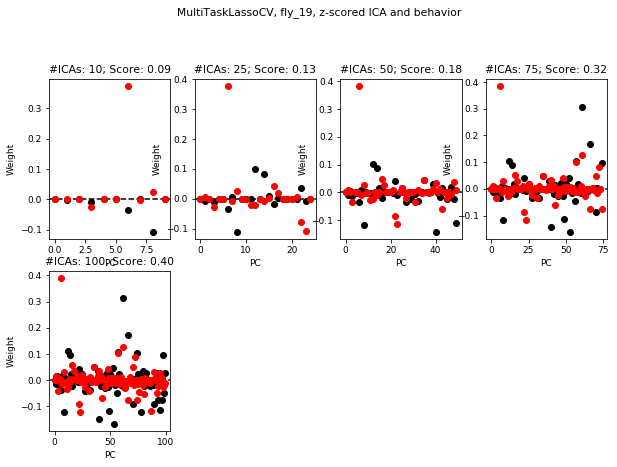

In [176]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 9})

for model_num in range(len(models_ica)):
    plt.subplot(3,4,model_num+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.plot(models_ica[model_num]['model'].coef_[0,:],'o',color='k')
    plt.plot(models_ica[model_num]['model'].coef_[1,:],'o',color='r')
    plt.title('#ICAs: {}; Score: {:.2f}'.format(models_ica[model_num]['num_pcs'],
                                               models_ica[model_num]['score']))

    plt.ylabel('Weight')
    plt.xlabel('PC')

plt.suptitle('MultiTaskLassoCV, fly_19, z-scored ICA and behavior')

# Lets look at behavior predictions

In [94]:
#Y_glm = np.vstack((fictracs['Y'], fictracs['Z'])).T
X_glm = pca_loadings[:,:1000]
prediction = models[-2]['model'].predict(X_glm)

In [95]:
np.shape(prediction)

(4554, 2)

In [115]:
timestamps[:,25].shape

(4554,)

Text(0.5, 0.98, 'MultiTaskLassoCV, fly_19, z-scored PCs and behavior, r2 = 0.51, 1000 PCs')

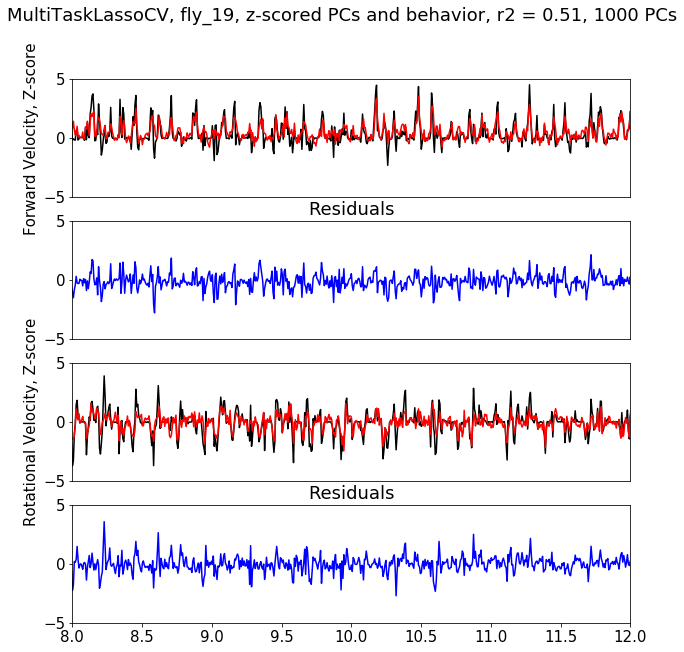

In [155]:
plt.figure(figsize=(10,10))

x = timestamps[:,25]/1000/60




ax_Y = plt.subplot(4,1,1)
ax_Y.plot(x, fictracs['Y'],color='k')
ax_Y.plot(x, prediction[:,0],color='r')
ax_Y.set_ylim(-5,5)

ax_Y_residual = plt.subplot(4,1,2, sharex = ax_Y, sharey = ax_Y)
ax_Y_residual.plot(x, fictracs['Y'] - prediction[:,0],color='blue')
ax_Y_residual.set_title('Residuals')

ax_Z = plt.subplot(4,1,3, sharex = ax_Y, sharey = ax_Y)
ax_Z.plot(x, fictracs['Z'],color='k')
ax_Z.plot(x, prediction[:,1],color='r')

ax_Z_residual = plt.subplot(4,1,4, sharex = ax_Y, sharey = ax_Y)
ax_Z_residual.plot(x, fictracs['Z']-prediction[:,1],color='blue')
ax_Z_residual.set_title('Residuals')




ax_Y.xaxis.set_visible(False)
ax_Y_residual.xaxis.set_visible(False)
ax_Z.xaxis.set_visible(False)


ax_Y.set_ylabel('Forward Velocity, Z-score')
ax_Z.set_ylabel('Rotational Velocity, Z-score')
ax_Z.set_xlabel('Time, min')

plt.xlim(8,12)
plt.ylim(-5,5)
plt.suptitle('MultiTaskLassoCV, fly_19, z-scored PCs and behavior, r2 = 0.51, 1000 PCs')

Text(0.5, 0.98, 'MultiTaskLassoCV, fly_19, z-scored PCs and behavior, r2 = 0.51, 1000 PCs')

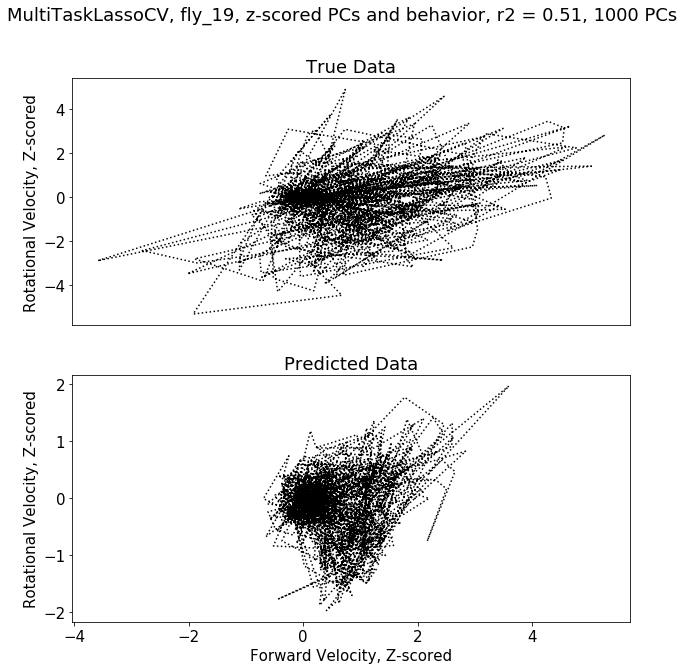

In [158]:
plt.figure(figsize=(10,10))

stop = 1000

ax_true = plt.subplot(2,1,1)
ax_true.plot(fictracs['Y'][:stop], fictracs['Z'][:stop],color='k',linestyle=':')
ax_true.set_ylabel('Rotational Velocity, Z-scored')
ax_true.xaxis.set_visible(False)
ax_true.set_title('True Data')

ax_predict = plt.subplot(2,1,2, sharex = ax_true)
ax_predict.plot(prediction[:,0][:stop], prediction[:,1][:stop],color='k',linestyle=':')
ax_predict.set_ylabel('Rotational Velocity, Z-scored')
ax_predict.set_xlabel('Forward Velocity, Z-scored')
ax_predict.set_title('Predicted Data')

plt.suptitle('MultiTaskLassoCV, fly_19, z-scored PCs and behavior, r2 = 0.51, 1000 PCs')

# Plot PC_2D_hist_behavior

In [235]:
#### Bin PCs

pcs_binned = []
for i in range(50):
    pcs_binned.append(bin_pc(pca_loadings[:,i], num_bins_x, num_bins_y, idx_x ,idx_y))

In [236]:
plt.rcParams.update({'font.size': 20})

In [241]:
Y_coef = models[-1]['model'].coef_[0,:]
Z_coef = models[-1]['model'].coef_[1,:]

Text(0.5, 0.9, 'Fly_19. Purple=Forward; Green=Rotation')

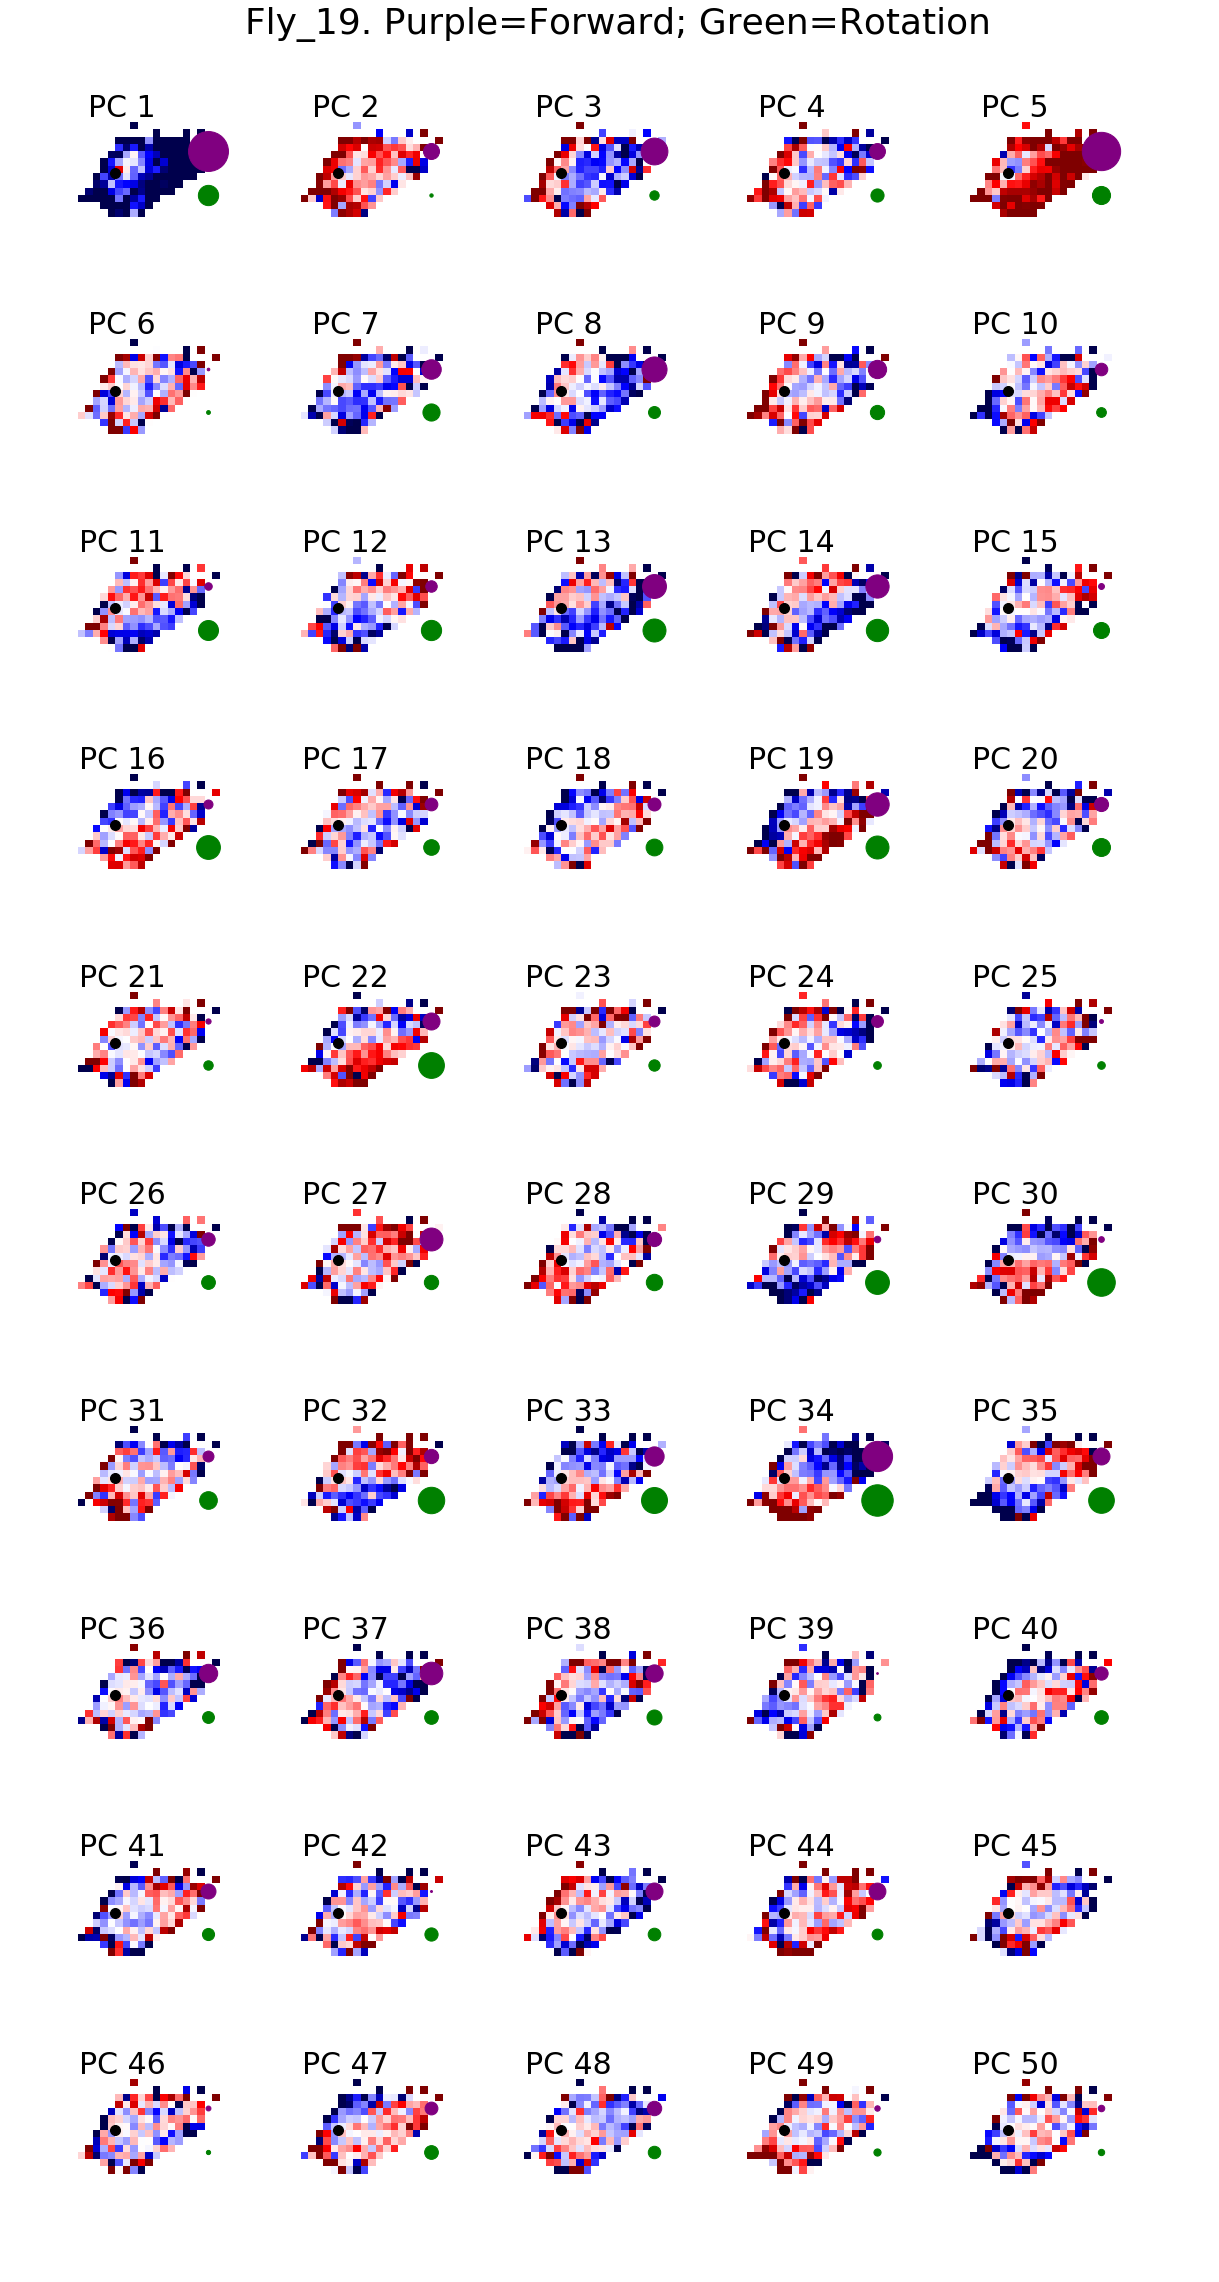

In [246]:
## Bin PCs into behavior bins

# For each bin in the histogram, it has collected several points from across time.
# Find those frame numbers.
# Then, get average value of PC across those timepoints!

def bin_pc(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def smooth_with_nans(U):
    mode = 'reflect'
    truncate = 1
    sigma = 5

    V=U.copy()
    V[np.isnan(U)]=0
    VV=sp.ndimage.gaussian_filter(V,sigma=sigma,mode=mode,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=sp.ndimage.gaussian_filter(W,sigma=sigma,mode=mode,truncate=truncate)

    Z=VV/WW
    return Z

#### Create behavior bins and get indicies

num_bins_x, num_bins_y = 30, 30
start_x, end_x = -2, 10
start_y, end_y = -10, 10

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(fictracs['Y'],bins_x), np.digitize(fictracs['Z'],bins_y)



#### Plot

plt.figure(figsize=(20,40))
#norm = mpl.colors.LogNorm()
norm = None
contrast = 2
plt.rcParams.update({'font.size': 30})
pc_behavior_plots = []

for i in range(50):
    ax = plt.subplot(10,5,i+1)
    
    #pc_bin_smooth = smooth_with_nans(pcs_binned[i]['pc_binned'])
    #pc_std_smooth = smooth_with_nans(pcs_binned[i]['pc_std'])
    
    pc_bin_smooth = pcs_binned[i]['pc_binned']
    pc_std_smooth = pcs_binned[i]['pc_std']
    
    mask = ~np.isnan(pcs_binned[i]['pc_binned'])
    z_score = np.divide(pc_bin_smooth,pc_std_smooth)
    z_score_masked = np.multiply(z_score, mask)
    
    interp_mode = None
    ax.imshow(z_score_masked,
              cmap='seismic',
              aspect='auto',
              extent=(start_x,end_x,start_y,end_y),
              interpolation=interp_mode,
              norm=norm,
              vmin=-1,
              vmax=1)

    plt.scatter(0,0,100,color='k')
    plt.scatter(5,2,abs(Y_coef)[i]*5000,color='purple') # Y
    plt.scatter(5,-2,abs(Z_coef)[i]*5000,color='green') # Z
    ax.axis('off')
    ax.text(.2, .8,
             'PC {}'.format(i+1),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
    pc_behavior_plots.append(z_score_masked)

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Fly_19. Purple=Forward; Green=Rotation',x=.5,y=.9)

In [212]:
np.random.shuffle(pca_loadings[:,0])

In [213]:
pca_loadings[:,0]

array([-0.60842421,  1.19049552, -0.42058349, ..., -0.82229592,
        1.70009924, -1.18293764])

In [183]:
x = np.arange(0,10)

In [186]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [187]:
x_copy

array([7, 9, 1, 4, 3, 6, 8, 2, 0, 5])